In [30]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from kneed import KneeLocator
from matplotlib.dates import date2num
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

sns.set_theme(style='darkgrid')

# Data Loading & Inspection

In [31]:
df = pd.read_csv('./data/2020-season-player-statistics.csv')
# df.sample(5)

# Data Cleaning

In [32]:
# drop unneccesary columns for analysis
df.drop(
	labels=[
		'player_statistic_id',
		'player_id-2',
		'fixture_id',
		'is_starter',
		'created_at',
		'threes_attempted',
		'field_goals_attempted',
		'free_throws_attempted'
	],
	axis=1,
	inplace=True)

# convert player_status to binary categorical to easy dropping 0-minute games (i.e. games with null stats)
df.player_status = np.where(df.player_status.isna(), 1, 0)
# convert data to calendar date to aid binnng of date cut-off values
df.played_on = pd.to_datetime(df.played_on)
# drop all games with no data
df.dropna(inplace=True)
# recode positions to their primary
df.position_primary.replace({ 'PG': 'G', 'SG': 'G', 'PF': 'F', 'SF': 'F' }, inplace=True)

# # recode played_on to the appropriate cutoff date
# df['cutoff'] = df.played_on.apply(date2num)
# df.cutoff = pd.cut(df.iloc[:, -1], bins=3, labels=['early', 'mid', 'late'])

# convert seconds played to minutes
df['min'] = df.seconds_played.apply(lambda x: round(x / 60, 1))

# combine name
df['name'] = df.apply(lambda row: f'{row.first_name} {row.last_name}', axis=1)
# drop played_on since we only need it for creating the cutoff
df.drop(labels=['player_status', 'first_name', 'last_name', 'seconds_played'], axis=1, inplace=True)
# convert player id, position, and to categorical to avoid scaling
df.position_primary = df.position_primary.astype('category')
df.player_id = df.player_id.astype('category')

# reorder and rename columns for preference and succintness
df.columns = ['id', 'pos', 'played_on', 'pts', 'threes', 'fg', 'ft', 'oreb', 'dreb', 'ast', 'stl', 'blk', 'to', 'min', 'name']
df = df[['id', 'name', 'pos', 'played_on', 'min', 'pts', 'threes', 'fg', 'ft', 'oreb', 'dreb', 'ast', 'stl', 'blk', 'to']]
df.describe()

,min,pts,threes,fg,ft,oreb,dreb,ast,stl,blk,to
count,22154.000000,22154.000000,22154.000000,22154.000000,22154.000000,22154.000000,22154.000000,22154.000000,22154.000000,22154.000000,22154.000000
mean,23.400668,10.963934,1.237971,4.024555,1.676853,0.957118,3.365577,2.435091,0.742936,0.472691,1.306671
std,9.932018,8.591330,1.509407,3.190364,2.285986,1.338067,2.749394,2.625766,0.959596,0.831380,1.418078
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.600000,4.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,24.100000,9.000000,1.000000,3.000000,1.000000,0.000000,3.000000,2.000000,0.000000,0.000000,1.000000
75%,31.300000,16.000000,2.000000,6.000000,2.000000,1.000000,5.000000,4.000000,1.000000,1.000000,2.000000
max,50.500000,62.000000,11.000000,21.000000,19.000000,12.000000,20.000000,24.000000,10.000000,10.000000,10.000000


In [33]:
# create a lookup table for all players
players = pd.concat([df['id'], df['name'], df['pos']], axis=1).drop_duplicates()
# create all unique dates
game_dates = pd.DataFrame(df['played_on']).drop_duplicates()

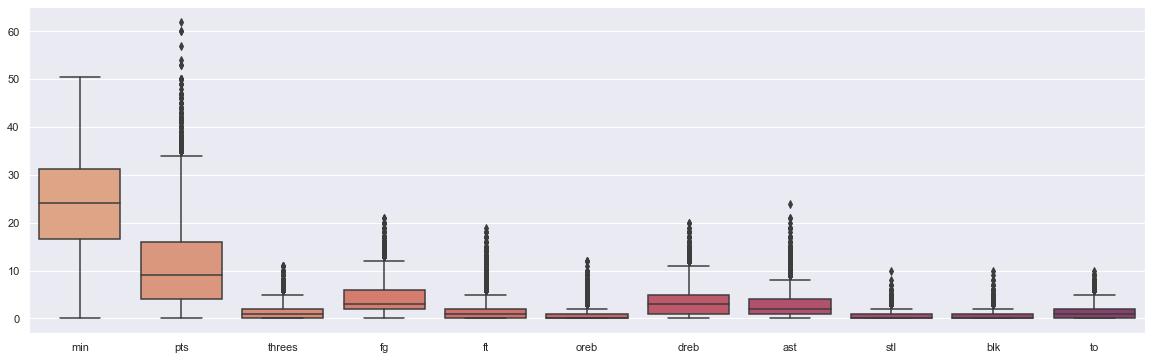

In [34]:
# plot the log-scaled boxplots for each feature post-cleaning
palette = sns.color_palette('flare', len(df.columns))
fig, ax = plt.subplots(1, figsize=(20, 6))
ax = sns.boxplot(data=df, palette=palette)
plt.show()

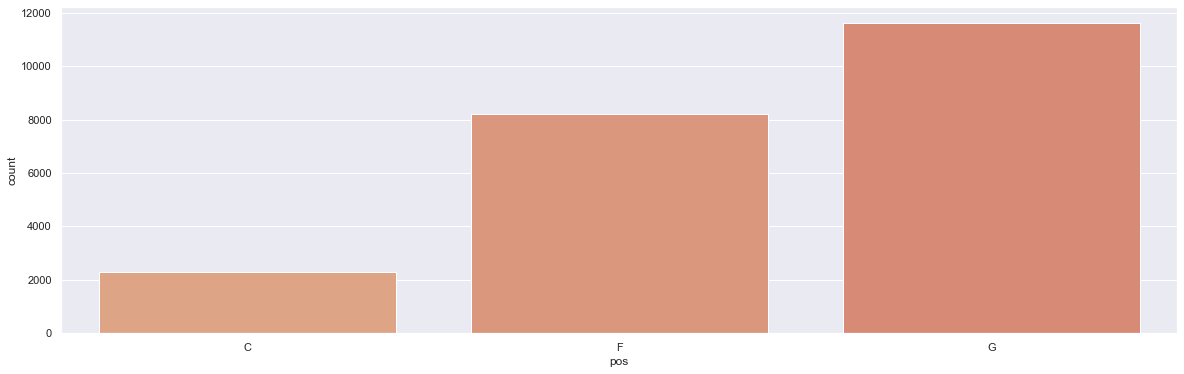

In [35]:
# plot the barchart for position
palette = sns.color_palette('flare', len(df.columns))
fig, ax = plt.subplots(1, figsize=(20, 6))
ax = sns.countplot(data=df, x='pos', palette=palette)
plt.show()

# Pre-Filtering

Here we define what position we'd like to evaluate given a timeframe. We pre-filter the data for only those positions that match the trading player and all games on or before a specified date. 

In [36]:
# define whether we want to run with a pre-seeded player or randomize all params
mode = 'TEST'

if mode != 'TEST':
	# get a random player and date
	trade_player = players.iloc[np.random.randint(len(players), size=1)[0], :].to_numpy()
	trade_date = game_dates.iloc[np.random.randint(len(game_dates), size=1)[0], :].to_numpy()
else:
	# for testing, use Buddy Heild and 02/20/21
	trade_player = players[players['id'] == 51].to_numpy()[0]
	trade_date = game_dates.loc[game_dates['played_on'] == '2021-02-18', :].to_numpy()[0]

trade_position = trade_player[2]

print(f'Trade player to evaluated: {trade_player}')
print(f'Trade deadline date: {trade_date}')

Trade player to evaluated: [51 'Buddy Hield' 'G']
Trade deadline date: ['2021-02-18T00:00:00.000000000']


In [37]:
# get every game for position and trade date; sort by player id to ensure consistency when rejoining with names
positional_game_data = df[(df['pos'] == trade_position) & (df['played_on'] <= trade_date[0])]
positional_game_data.sort_values(by=['id'], ascending=True)

,id,name,pos,played_on,min,pts,threes,fg,ft,oreb,dreb,ast,stl,blk,to
77,2,Damian Lillard,G,2020-12-11,22.1,15.0,3.0,4.0,4.0,0.0,1.0,5.0,0.0,0.0,1.0
107,2,Damian Lillard,G,2021-02-17,37.9,43.0,7.0,14.0,8.0,1.0,3.0,16.0,1.0,1.0,4.0
106,2,Damian Lillard,G,2021-02-16,37.0,31.0,5.0,12.0,2.0,2.0,5.0,10.0,2.0,0.0,3.0
105,2,Damian Lillard,G,2021-02-14,36.5,34.0,5.0,12.0,5.0,0.0,3.0,11.0,1.0,0.0,5.0
104,2,Damian Lillard,G,2021-02-12,29.6,20.0,0.0,7.0,6.0,0.0,3.0,9.0,1.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26103,432,Matt Thomas,G,2020-12-14,15.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
26102,432,Matt Thomas,G,2020-12-12,21.6,16.0,4.0,5.0,2.0,0.0,1.0,5.0,2.0,0.0,1.0
26132,432,Matt Thomas,G,2021-02-16,5.7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
26117,432,Matt Thomas,G,2021-01-18,2.1,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# get cumulative sums and remove the multi-index
data = positional_game_data.groupby('id').sum().groupby(level=0).cumsum()
data.reset_index(inplace=True)
# get player names and append
player_names = positional_game_data[['id', 'name']].drop_duplicates()
data = data.merge(player_names, left_on='id', right_on='id')
# move the player name
name = data.pop('name')
data.insert(1, 'name', name)
# create positional stats data that maintains all the stats
positional_stats = data.copy()
positional_stats

,id,name,min,pts,threes,fg,ft,oreb,dreb,ast,stl,blk,to
0,2,Damian Lillard,1035.6,839.0,116.0,258.0,207.0,14.0,111.0,219.0,33.0,7.0,90.0
1,3,Stephen Curry,1064.6,937.0,158.0,313.0,153.0,13.0,153.0,185.0,42.0,3.0,101.0
2,4,Chris Paul,885.0,456.0,38.0,173.0,72.0,15.0,117.0,227.0,33.0,7.0,68.0
3,5,Trae Young,1003.8,743.0,65.0,213.0,252.0,20.0,94.0,262.0,27.0,9.0,130.0
4,9,Kawhi Leonard,846.1,642.0,48.0,234.0,126.0,21.0,124.0,121.0,45.0,14.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,426,Tre Jones,49.8,22.0,1.0,7.0,7.0,5.0,2.0,6.0,1.0,1.0,3.0
200,428,Jalen Harris,18.6,3.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
201,429,Carsen Edwards,164.3,71.0,10.0,25.0,11.0,2.0,14.0,7.0,4.0,1.0,2.0
202,430,Rodney McGruder,80.8,27.0,3.0,10.0,4.0,4.0,8.0,6.0,1.0,1.0,6.0


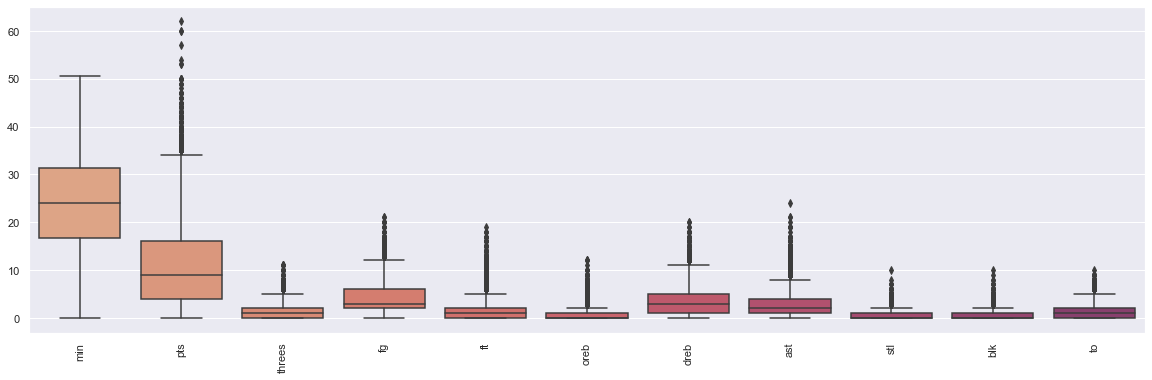

In [39]:
# plot the log-scaled boxplots for each feature
palette = sns.color_palette('flare', len(df.columns))
fig, ax = plt.subplots(1, figsize=(20, 6))
ax = sns.boxplot(data=df, palette=palette)
ax.tick_params(axis='x', labelrotation = 90)
plt.show()

# Feature Scaling

In [40]:
X = data.iloc[:, 2:]
# pipeline for transforming numerical data
disc_pipeline = make_pipeline(StandardScaler())
# define the current numerical features in a list for transformation and selection
disc_vars = list(X.select_dtypes(include=np.number).columns)
num_disc = len(disc_vars)
preprocessor = ColumnTransformer(transformers=[ ('discrete', disc_pipeline, disc_vars) ])
# code the numerical features and overwrite the old columns
X = preprocessor.fit_transform(X=X)
data.loc[:, disc_vars] = X

print(data.shape)
data.head(10)

(204, 13)


,id,name,min,pts,threes,fg,ft,oreb,dreb,ast,stl,blk,to
0,2,Damian Lillard,1.586784,2.815233,2.793329,2.241871,4.010880,0.036753,1.072595,2.498777,1.099130,0.003838,2.096986
1,3,Stephen Curry,1.686375,3.304473,4.283475,3.015596,2.709786,-0.060619,2.040473,1.925816,1.854936,-0.622474,2.511141
2,4,Chris Paul,1.069600,0.903204,0.025914,1.046115,0.758145,0.134125,1.210864,2.633592,1.099130,0.003838,1.268675
3,5,Trae Young,1.477578,2.335978,0.983865,1.608824,5.095125,0.620986,0.680835,3.223405,0.595259,0.316994,3.603006
4,9,Kawhi Leonard,0.936012,1.831761,0.380711,1.904246,2.059239,0.718359,1.372176,0.847299,2.106871,1.099883,0.553315
5,13,Kyrie Irving,0.728932,1.701963,1.019345,1.904246,0.999088,0.718359,0.496478,0.948410,0.427302,1.569617,0.854519
6,14,Luka Doncic,1.555190,2.845186,1.196743,2.706106,3.649465,1.302592,3.607513,3.341368,0.595259,1.726195,3.301802
7,15,Devin Booker,1.173312,1.856723,0.629069,1.904246,2.011050,-0.936969,0.703880,0.796744,0.175367,0.003838,2.247588
8,16,Bradley Beal,1.081963,2.675450,0.841947,2.607632,3.408522,2.081569,0.657791,0.796744,1.099130,1.099883,1.682830
9,20,Jrue Holiday,0.858743,0.658584,0.309751,0.877302,-0.036968,1.789453,0.611701,1.150632,2.190849,1.256461,0.327412


# Cluster Evaluation

In the following code, we calculate the inertia for increasing number of clusters. This allows us to determine the optimal number of clusters to use for the dataset.

### KMeans

<function matplotlib.pyplot.show(close=None, block=None)>

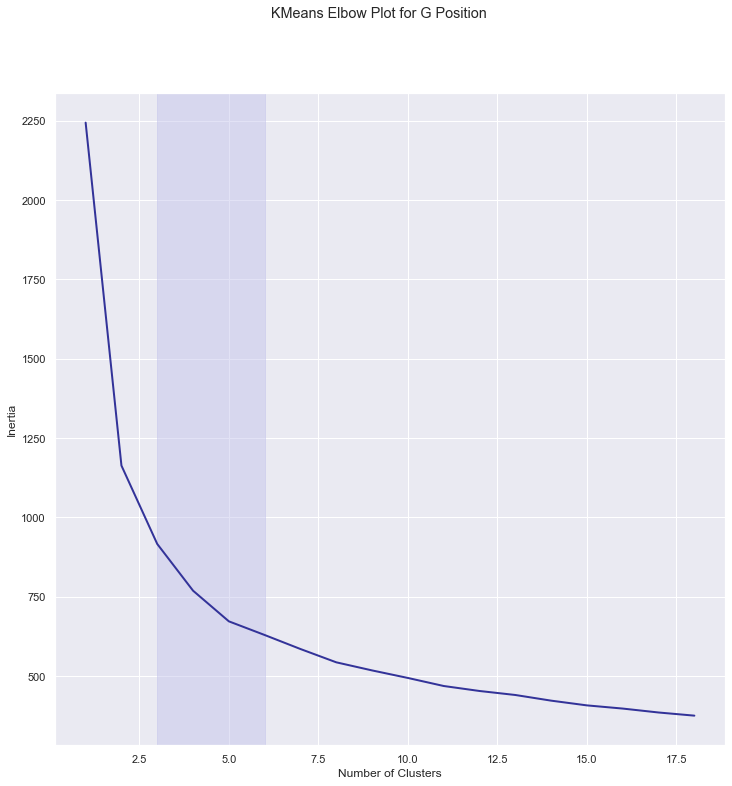

In [41]:
# iteratively calculate the inertia for increasing number of clusters
inertias = []

n_clusters = 19
n = list(range(1, n_clusters))

for i in n:
	clf = KMeans(n_clusters=i)
	clf.fit(X=X)
	inertias.append(clf.inertia_)

fig, ax = plt.subplots(1, figsize=(12, 12))
ax = sns.lineplot(x=n, y=inertias, color='#333399', linewidth=2)
ax.axvspan(3, 6, alpha=0.5, color='#c6c6ec')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
plt.suptitle(f'KMeans Elbow Plot for {trade_position} Position')
plt.show

In [42]:
# use the Knee package to automatically calculate the optimal number of clusters w/o visual inspection
kl = KneeLocator(range(1, 19), inertias, curve='convex', direction='decreasing')
optimal_clusters = kl.elbow

print(f'Optimal clusters: {optimal_clusters}')

Optimal clusters: 4


### DBSCAN

<function matplotlib.pyplot.show(close=None, block=None)>

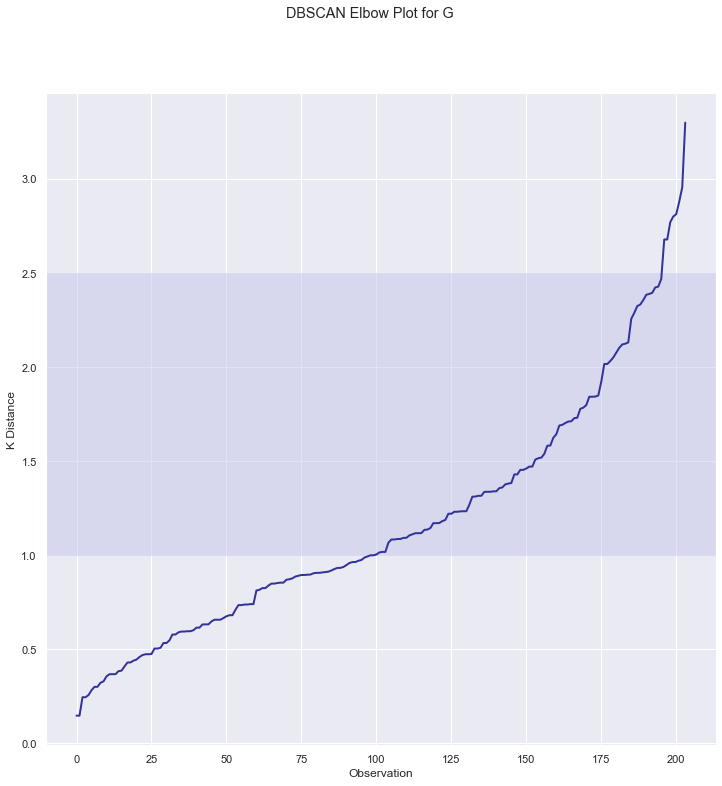

In [43]:
# get the minimum distance to nearest 22 neighbors
neighbors = NearestNeighbors(n_neighbors=22)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# sort the distances to get the minimum
distances = np.sort(distances, axis=0)
distances = distances[:, 1] 

fig, ax = plt.subplots(1, figsize=(12, 12))
ax = sns.lineplot(
	x=[ i for i in range(len(indices)) ], 
	y=distances, color='#333399', 
	linewidth=2)
ax.axhspan(1, 2.5, alpha=0.5, color='#c6c6ec')
ax.set_xlabel('Observation')
ax.set_ylabel('K Distance')
plt.suptitle(f'DBSCAN Elbow Plot for {trade_position}')
plt.show

In [44]:
optimal_eps = 2.5

# Dimensionality Reduction

Here we use the explained variance ratio for increasing number of components and see which number explains the most amount of variance in the data.

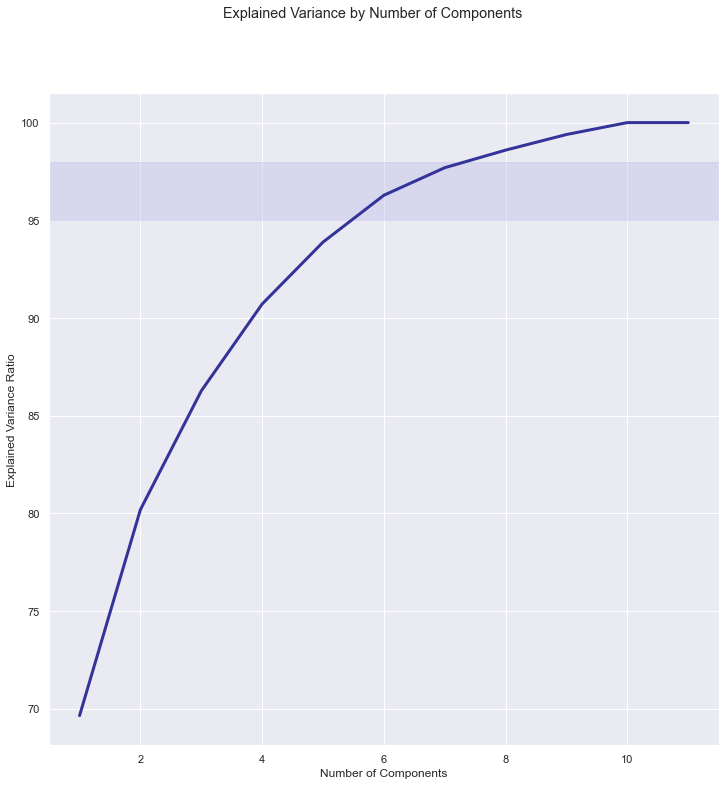

In [45]:
# define max number of components
components = list(range(1, num_disc + 1))
# compute the explained variance ratios and plot them
pca = PCA(n_components=num_disc)
pca.fit(X)
variance_ratios = pca.explained_variance_ratio_
variances = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

fig, ax = plt.subplots(1, figsize=(12, 12))
sns.lineplot(x=components, y=variances, linewidth=3, color='#333399', ax=ax)
ax.axhspan(95, 98, alpha=0.5, color='#c6c6ec')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance Ratio')
plt.suptitle('Explained Variance by Number of Components')
plt.show()

In [46]:
optimal_components = 6

# Cluster Pipeline for 2D Dimensionality-Reduced Data

In the following code, we reduce the components down to 2 dimensions with the optimal number of clusters from prior analysis. Despite only explaining about 77% of the variance in the data, reducing down to 2 components allows us to visualize clusters.

### KMeans 2D Plot

Silhouette Score: 0.4218410708284294


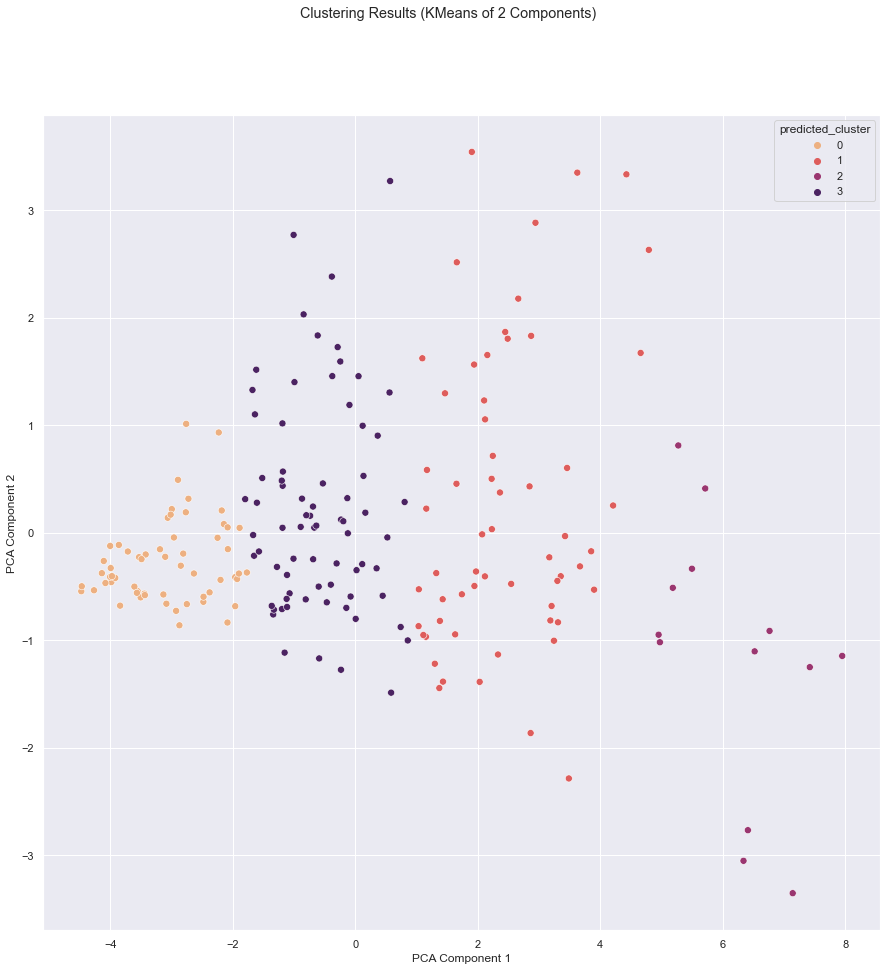

In [47]:
# create a pipeline that conducts a transformation (PCA) then Kmeans modelling
reducer = Pipeline([('pca', PCA(n_components=2, random_state=42))])
model = Pipeline([('kmeans', KMeans(n_clusters=optimal_clusters, random_state=42))])

pipe = Pipeline([('preprocessor', reducer), ('model', model)])
pipe.fit(X)

# extract the pre-processed data and predicted clusters for metrics and plotting
preprocessed_data = pipe['preprocessor'].transform(X)
predicted_clusters = pipe['model']['kmeans'].labels_

print(f'Silhouette Score: {silhouette_score(preprocessed_data, predicted_clusters)}')

# create a dataframe for plotting
pca_df = pd.DataFrame(preprocessed_data, columns=['PCA Component 1', 'PCA Component 2'])
pca_df['predicted_cluster'] = predicted_clusters

fig, ax = plt.subplots(1, figsize=(15, 15))
ax = sns.scatterplot(
	data=pca_df,
	x='PCA Component 1',
	y='PCA Component 2',
	s=50,
	hue='predicted_cluster',
	palette='flare',
)
plt.suptitle('Clustering Results (KMeans of 2 Components)')
plt.show()

### DBSCAN 2D Plot

Silhouette Score: 0.3754226495276965


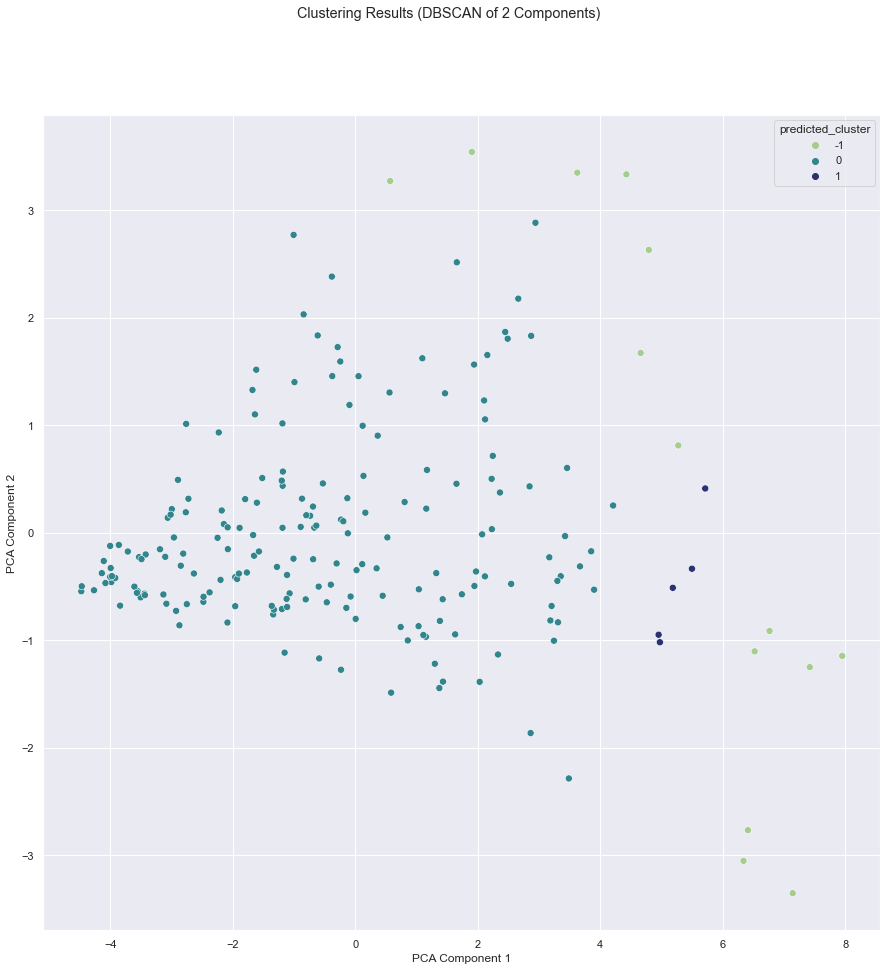

In [48]:
# create a pipeline that conducts a transformation (PCA) then Affinity modelling
reducer = Pipeline([('pca', PCA(n_components=2, random_state=42))])
model = Pipeline([('affinity', DBSCAN(eps=1))])

pipe = Pipeline([('preprocessor', reducer), ('model', model)])
pipe.fit(X)

# extract the pre-processed data and predicted clusters for metrics and plotting
preprocessed_data = pipe['preprocessor'].transform(X)
predicted_clusters = pipe['model']['affinity'].labels_

print(f'Silhouette Score: {silhouette_score(preprocessed_data, predicted_clusters)}')

# create a dataframe for plotting
pca_df = pd.DataFrame(preprocessed_data, columns=['PCA Component 1', 'PCA Component 2'])
pca_df['predicted_cluster'] = predicted_clusters

fig, ax = plt.subplots(1, figsize=(15, 15))
ax = sns.scatterplot(
	data=pca_df,
	x='PCA Component 1',
	y='PCA Component 2',
	s=50,
	hue='predicted_cluster',
	palette='crest',
)
plt.suptitle('Clustering Results (DBSCAN of 2 Components)')
plt.show()

# Cluster Pipeline for Optimal Components and Clusters

In the following code, we use *both* the optimal number of clusters and optimal number of components (i.e. least inertia and most explained variance).

In [49]:
# create a pipeline that conducts a transformation (PCA) then Kmeans modelling
reducer = Pipeline([('pca', PCA(n_components=optimal_components, random_state=42))])
kmeans = Pipeline([('kmeans', KMeans(n_clusters=optimal_clusters, random_state=42))])
dbscan = Pipeline([('dbscan', DBSCAN(eps=optimal_eps, min_samples=2))])

# create pipeline for all steps and fit
pipe1 = Pipeline([('preprocessor', reducer), ('model', kmeans)])
pipe1.fit(X)

pipe2 = Pipeline([('preprocessor', reducer), ('model', dbscan)])
pipe2.fit(X)

# add the clusters to the data
data['kmeans'] = pipe1['model']['kmeans'].labels_
positional_stats['kmeans'] = pipe1['model']['kmeans'].labels_
data['dbscan'] = pipe2['model']['dbscan'].labels_
positional_stats['dbscan'] = pipe2['model']['dbscan'].labels_

# convert to categorical
data['kmeans'] = data['kmeans'].astype('category')
positional_stats['kmeans'] = positional_stats['kmeans'].astype('category')
data['dbscan'] = data['dbscan'].astype('category')
positional_stats['dbscan'] = positional_stats['dbscan'].astype('category')
positional_stats

,id,name,min,pts,threes,fg,ft,oreb,dreb,ast,stl,blk,to,kmeans,dbscan
0,2,Damian Lillard,1035.6,839.0,116.0,258.0,207.0,14.0,111.0,219.0,33.0,7.0,90.0,2,0
1,3,Stephen Curry,1064.6,937.0,158.0,313.0,153.0,13.0,153.0,185.0,42.0,3.0,101.0,2,0
2,4,Chris Paul,885.0,456.0,38.0,173.0,72.0,15.0,117.0,227.0,33.0,7.0,68.0,0,1
3,5,Trae Young,1003.8,743.0,65.0,213.0,252.0,20.0,94.0,262.0,27.0,9.0,130.0,2,-1
4,9,Kawhi Leonard,846.1,642.0,48.0,234.0,126.0,21.0,124.0,121.0,45.0,14.0,49.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,426,Tre Jones,49.8,22.0,1.0,7.0,7.0,5.0,2.0,6.0,1.0,1.0,3.0,1,1
200,428,Jalen Harris,18.6,3.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1,1
201,429,Carsen Edwards,164.3,71.0,10.0,25.0,11.0,2.0,14.0,7.0,4.0,1.0,2.0,1,1
202,430,Rodney McGruder,80.8,27.0,3.0,10.0,4.0,4.0,8.0,6.0,1.0,1.0,6.0,1,1


# Post-Clustering Analysis

In [50]:
# determine which cluster our target player is in
positional_stats[positional_stats.name == trade_player[1]]

,id,name,min,pts,threes,fg,ft,oreb,dreb,ast,stl,blk,to,kmeans,dbscan
21,51,Buddy Hield,1066.8,498.0,122.0,165.0,46.0,10.0,131.0,95.0,29.0,11.0,59.0,0,1


In [51]:
print(f'{trade_player[1]} is in kmeans cluster {data[data.name == trade_player[1]].kmeans.values[0]}')
print(f'{trade_player[1]} is in dbscan cluster {data[data.name == trade_player[1]].dbscan.values[0]}')

Buddy Hield is in kmeans cluster 0
Buddy Hield is in dbscan cluster 1


In [52]:
# get average of each stat by cluster
positional_stats.groupby('kmeans').mean().sort_values(by='min', ascending=False)

,min,pts,threes,fg,ft,oreb,dreb,ast,stl,blk,to
kmeans,,,,,,,,,,,
2,1017.535714,749.785714,85.214286,258.428571,147.714286,22.000000,132.500000,196.000000,34.000000,12.714286,96.714286
0,861.501887,438.150943,57.471698,159.245283,62.188679,22.735849,104.886792,105.830189,28.981132,11.264151,53.301887
3,570.030263,229.500000,33.381579,83.118421,29.881579,12.184211,57.802632,62.000000,21.315789,6.644737,28.434211
1,225.818033,81.229508,13.557377,28.639344,10.393443,5.573770,22.000000,22.327869,7.049180,2.344262,10.786885


In [53]:
# get average of each stat by cluster
positional_stats.groupby('dbscan').mean().sort_values(by='min', ascending=False)

,min,pts,threes,fg,ft,oreb,dreb,ast,stl,blk,to
dbscan,,,,,,,,,,,
0,1050.100000,888.000000,137.000000,285.500000,180.000000,13.500000,132.000000,202.000000,37.500000,5.000000,95.500000
2,1031.600000,764.666667,76.333333,263.333333,161.666667,21.333333,209.666667,269.000000,29.666667,17.333333,118.666667
-1,832.933333,460.333333,47.333333,151.333333,110.333333,20.333333,77.333333,117.666667,31.000000,25.666667,67.333333
1,557.696429,258.494898,35.500000,93.403061,36.188776,13.403061,61.346939,65.627551,19.413265,6.551020,31.882653


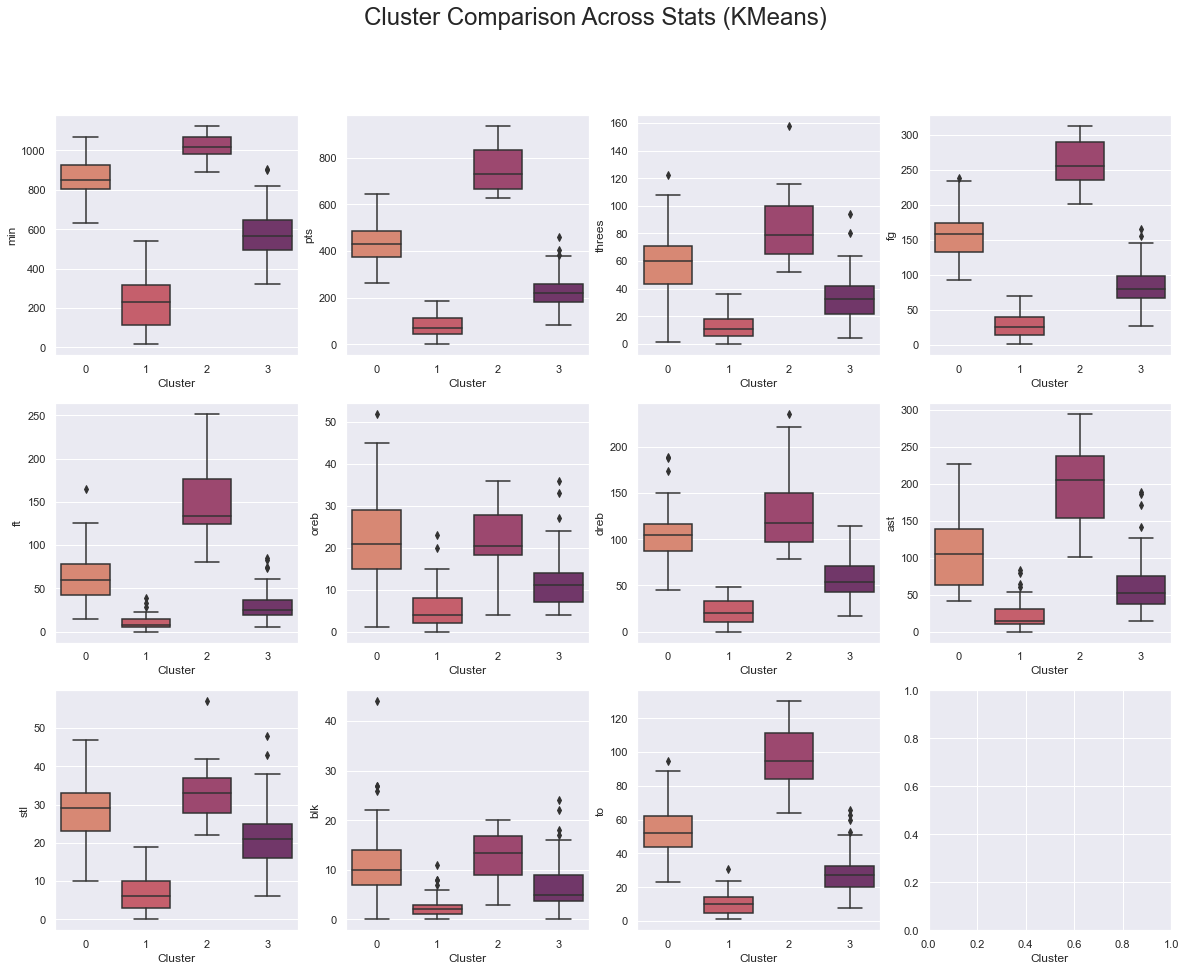

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 4, figsize=(20, 15))
sns.boxplot(data=positional_stats[['min', 'kmeans']], x='kmeans', y='min', palette='flare', ax=ax1[0])
sns.boxplot(data=positional_stats[['pts', 'kmeans']], x='kmeans', y='pts', palette='flare', ax=ax1[1])
sns.boxplot(data=positional_stats[['threes', 'kmeans']], x='kmeans', y='threes', palette='flare', ax=ax1[2])
sns.boxplot(data=positional_stats[['fg', 'kmeans']], x='kmeans', y='fg', palette='flare', ax=ax1[3])
sns.boxplot(data=positional_stats[['ft', 'kmeans']], x='kmeans', y='ft', palette='flare', ax=ax2[0])
sns.boxplot(data=positional_stats[['oreb', 'kmeans']], x='kmeans', y='oreb', palette='flare', ax=ax2[1])
sns.boxplot(data=positional_stats[['dreb', 'kmeans']], x='kmeans', y='dreb', palette='flare', ax=ax2[2])
sns.boxplot(data=positional_stats[['ast', 'kmeans']], x='kmeans', y='ast', palette='flare', ax=ax2[3])
sns.boxplot(data=positional_stats[['stl', 'kmeans']], x='kmeans', y='stl', palette='flare', ax=ax3[0])
sns.boxplot(data=positional_stats[['blk', 'kmeans']], x='kmeans', y='blk', palette='flare', ax=ax3[1])
sns.boxplot(data=positional_stats[['to', 'kmeans']], x='kmeans', y='to', palette='flare', ax=ax3[2])

ax1[0].set_xlabel('Cluster')
ax1[1].set_xlabel('Cluster')
ax1[2].set_xlabel('Cluster')
ax1[3].set_xlabel('Cluster')
ax2[0].set_xlabel('Cluster')
ax2[1].set_xlabel('Cluster')
ax2[2].set_xlabel('Cluster')
ax2[3].set_xlabel('Cluster')
ax3[0].set_xlabel('Cluster')
ax3[1].set_xlabel('Cluster')
ax3[2].set_xlabel('Cluster')
ax3[3].set_xlabel('Cluster')

plt.suptitle('Cluster Comparison Across Stats (KMeans)', fontsize=24)
plt.savefig('./plots/guard_kmeans_analysis.png', dpi=300)
plt.show()

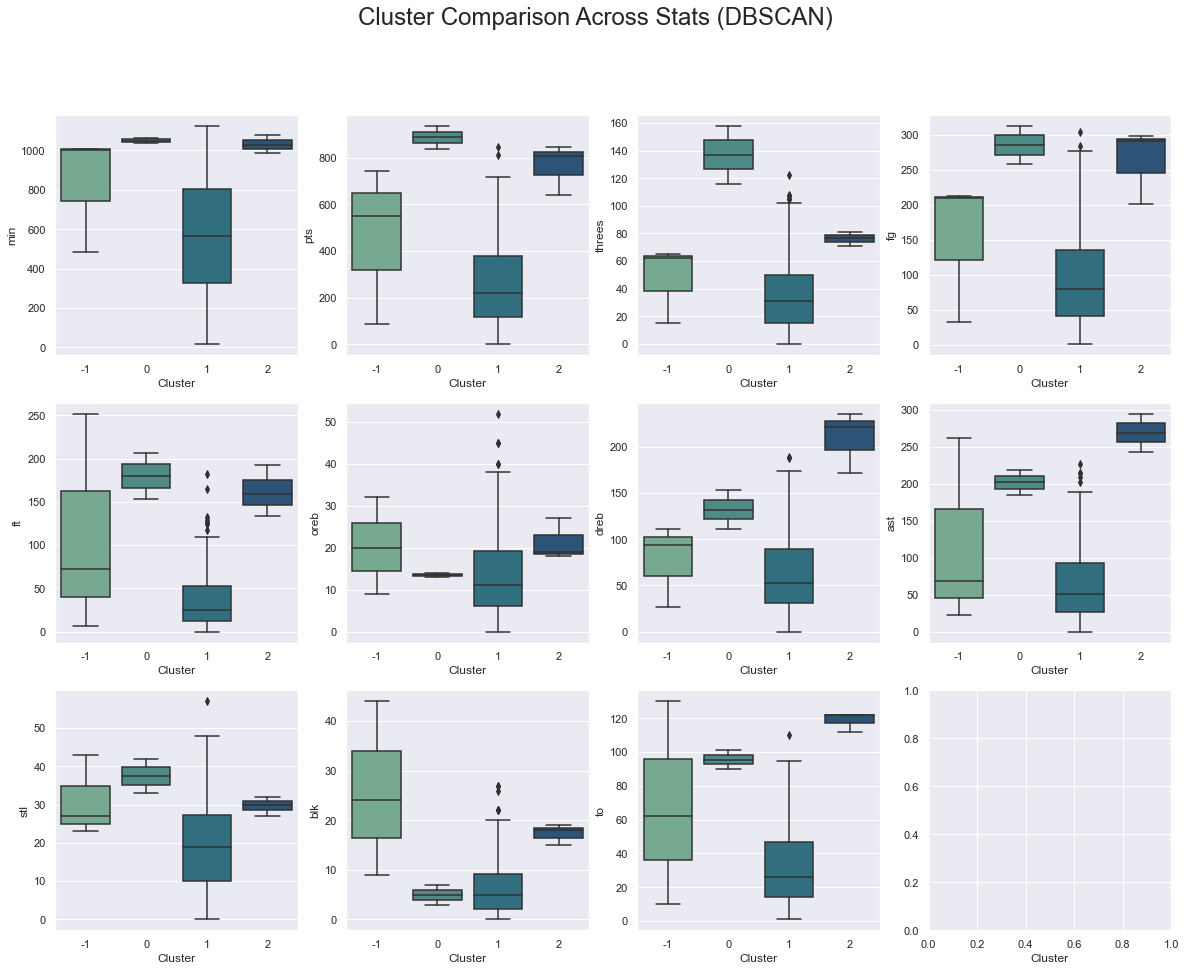

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 4, figsize=(20, 15))
sns.boxplot(data=positional_stats[['min', 'dbscan']], x='dbscan', y='min', palette='crest', ax=ax1[0])
sns.boxplot(data=positional_stats[['pts', 'dbscan']], x='dbscan', y='pts', palette='crest', ax=ax1[1])
sns.boxplot(data=positional_stats[['threes', 'dbscan']], x='dbscan', y='threes', palette='crest', ax=ax1[2])
sns.boxplot(data=positional_stats[['fg', 'dbscan']], x='dbscan', y='fg', palette='crest', ax=ax1[3])
sns.boxplot(data=positional_stats[['ft', 'dbscan']], x='dbscan', y='ft', palette='crest', ax=ax2[0])
sns.boxplot(data=positional_stats[['oreb', 'dbscan']], x='dbscan', y='oreb', palette='crest', ax=ax2[1])
sns.boxplot(data=positional_stats[['dreb', 'dbscan']], x='dbscan', y='dreb', palette='crest', ax=ax2[2])
sns.boxplot(data=positional_stats[['ast', 'dbscan']], x='dbscan', y='ast', palette='crest', ax=ax2[3])
sns.boxplot(data=positional_stats[['stl', 'dbscan']], x='dbscan', y='stl', palette='crest', ax=ax3[0])
sns.boxplot(data=positional_stats[['blk', 'dbscan']], x='dbscan', y='blk', palette='crest', ax=ax3[1])
sns.boxplot(data=positional_stats[['to', 'dbscan']], x='dbscan', y='to', palette='crest', ax=ax3[2])

ax1[0].set_xlabel('Cluster')
ax1[1].set_xlabel('Cluster')
ax1[2].set_xlabel('Cluster')
ax1[3].set_xlabel('Cluster')
ax2[0].set_xlabel('Cluster')
ax2[1].set_xlabel('Cluster')
ax2[2].set_xlabel('Cluster')
ax2[3].set_xlabel('Cluster')
ax3[0].set_xlabel('Cluster')
ax3[1].set_xlabel('Cluster')
ax3[2].set_xlabel('Cluster')
ax3[3].set_xlabel('Cluster')

plt.suptitle('Cluster Comparison Across Stats (DBSCAN)', fontsize=24)
plt.savefig('./plots/guard_dbscan_analysis.png', dpi=300)
plt.show()

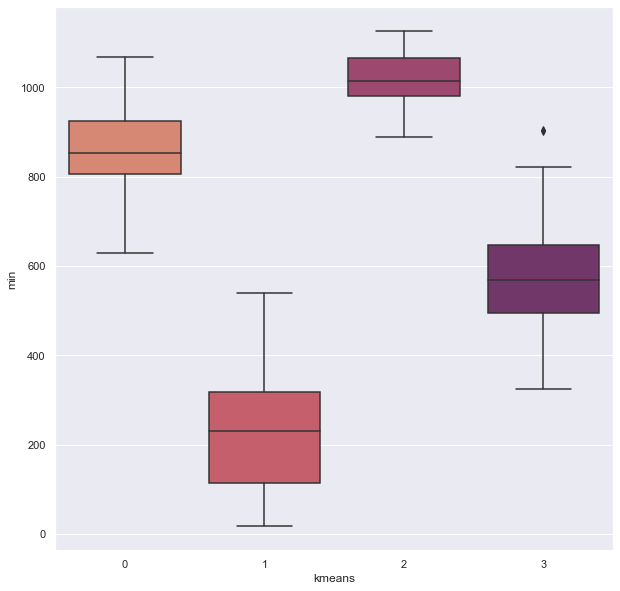

In [56]:
# sample boxplot for single feature
fig, ax = plt.subplots(1, figsize=(10, 10))
ax = sns.boxplot(data=positional_stats[['min', 'kmeans']], x='kmeans', y='min', palette='flare')
plt.show()

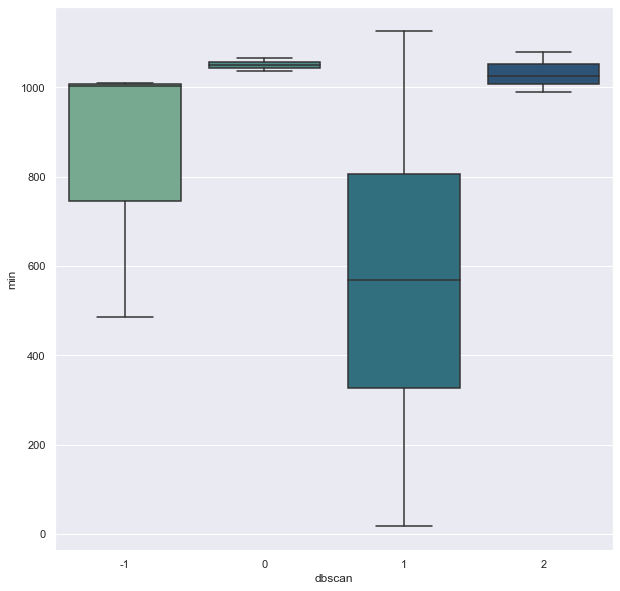

In [57]:
# sample boxplot for single feature
fig, ax = plt.subplots(1, figsize=(10, 10))
ax = sns.boxplot(data=positional_stats[['min', 'dbscan']], x='dbscan', y='min', palette='crest')
plt.show()